Device: cpu
Class weights: tensor([0.3591, 0.6409])
PopularityMLP(
  (net): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)
[01] train_loss=0.6960 | test_acc=66.67%
[02] train_loss=0.6852 | test_acc=64.96%
[03] train_loss=0.6784 | test_acc=62.39%
[04] train_loss=0.6725 | test_acc=63.25%
[05] train_loss=0.6671 | test_acc=64.96%
[06] train_loss=0.6624 | test_acc=63.25%
[07] train_loss=0.6602 | test_acc=63.25%
[08] train_loss=0.6519 | test_acc=64.96%
[09] train_loss=0.6506 | test_acc=65.81%
[10] train_loss=0.6474 | test_acc=67.52%
[11] train_loss=0.6380 | test_acc=64.96%
[12] train_loss=0.6371 | test_acc=64.96%
[13] train_loss=0.6278 | test_acc=63.25%
[14] train_loss=0.6257 | test_acc=64.96%
[15] train_loss=0.6173 | test_acc=64.96%

=== Classification report ===
              precision    recall  f1-score   sup

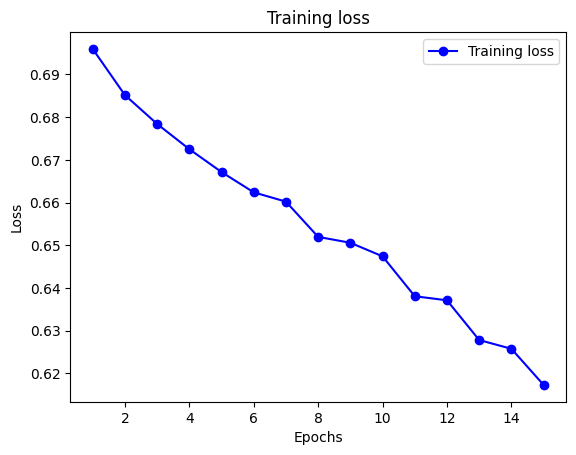

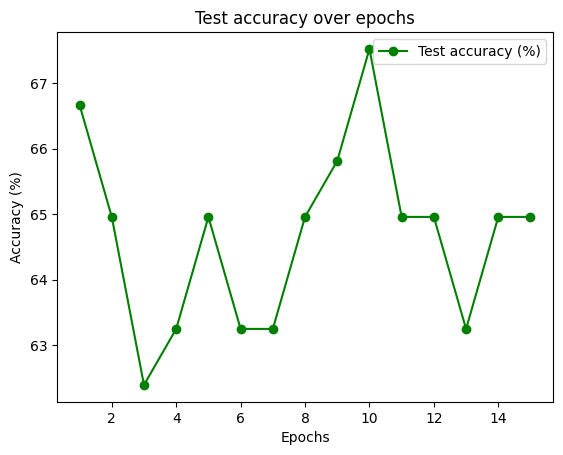

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

torch.manual_seed(42)

# ======================
# 1. завантаження даних
# ======================

df = pd.read_csv("taylor_swift_spotify.csv")
df = df.dropna()

# видалення текстових колонок
df = df.drop(columns=['Unnamed: 0', 'name', 'album', 'id', 'uri', 'release_date'],
             errors='ignore')

target_col = 'popularity'

# --- створення 2 класів (замість 3) ---
# 0 = Low + Medium
# 1 = High
threshold = df[target_col].quantile(2/3)
df['label'] = (df[target_col] >= threshold).astype(int)

y = df['label']
X = df.drop(columns=[target_col, 'label'])

# масштабування
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ======================
# 2. torch tensors
# ======================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)

y_train_t = torch.tensor(y_train.values, dtype=torch.long)
y_test_t  = torch.tensor(y_test.values, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

input_dim = X_train_t.shape[1]
num_classes = 2

# ---- class weights ----
class_counts = y_train.value_counts().sort_index()
weights = 1.0 / class_counts
weights = weights / weights.sum()
weights = torch.tensor(weights.values, dtype=torch.float32).to(device)

print("Class weights:", weights)

# ======================
# 3. Модель MLP
# ======================

class PopularityMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = PopularityMLP().to(device)
print(model)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ======================
# 4. Training loop
# ======================

n_epochs = 15
train_loss_history = []
test_acc_history = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)

    # test accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    acc = correct / total
    test_acc_history.append(acc)

    print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | test_acc={acc*100:.2f}%")

# ======================
# 5. Classification report
# ======================

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(dim=1)
        all_preds.append(preds.cpu())
        all_true.append(yb.cpu())

all_preds = torch.cat(all_preds).numpy()
all_true = torch.cat(all_true).numpy()

print("\n=== Classification report ===")
print(classification_report(all_true, all_preds,
                            target_names=['Not High', 'High']))

cm = confusion_matrix(all_true, all_preds)
print("Confusion matrix:\n", cm)

# ======================
# 6. Loss plot
# ======================

epochs = range(1, n_epochs+1)
plt.plot(epochs, train_loss_history, "bo-", label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training loss")
plt.legend()
plt.show()

# ======================
# 7. Accuracy plot
# ======================

plt.plot(epochs, np.array(test_acc_history)*100, "go-", label="Test accuracy (%)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test accuracy over epochs")
plt.legend()
plt.show()



Device: cpu
[Simple CNN][Epoch 1] loss=0.6480 | acc=67.13%
[Simple CNN][Epoch 2] loss=0.5633 | acc=69.40%
[Simple CNN][Epoch 3] loss=0.5148 | acc=73.26%
[ResNet18] train_loss (100 batches): 0.6349
[ResNet18] test_acc=71.82%


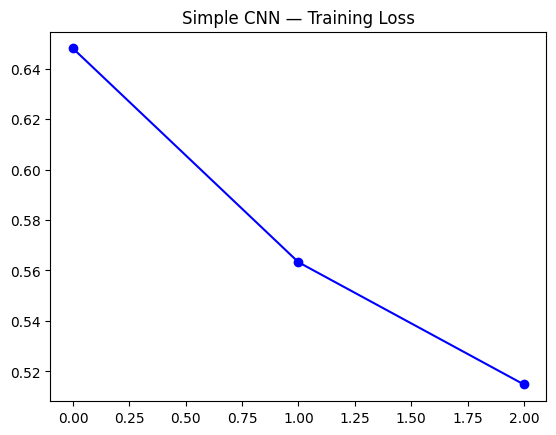

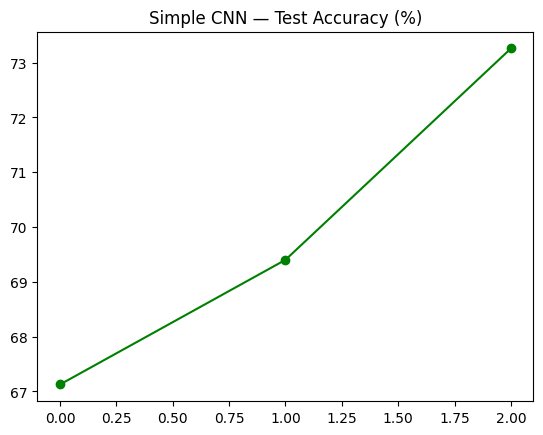


========== ПОРІВНЯННЯ МОДЕЛЕЙ ==========
Simple CNN Accuracy:  73.26%
ResNet18 Accuracy:    71.82%


In [7]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os

torch.manual_seed(42)

# ===============================
# 1) розпаковка архівів
# ===============================

!unzip -q training_set.zip
!unzip -q test_set.zip

train_dir = "/content/training_set"
test_dir  = "/content/test_set"

# ===============================
# 2) трансформації і dataloaders
# ===============================

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder(train_dir, transform=transform)
test_set  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =======================================================
# 3) cnn
# =======================================================

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     # 64 → 32

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)      # 32 → 16
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 2)   # 2 класи cat/dog
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

simple_cnn = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_cnn.parameters(), lr=1e-3)

# =======================================================
# 4) навчання cnn
# =======================================================

n_epochs = 3
simple_train_loss = []
simple_test_acc = []

for epoch in range(n_epochs):
    simple_cnn.train()
    run_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out = simple_cnn(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()

    # --- test accuracy ---
    simple_cnn.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = simple_cnn(xb).argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    acc = correct / total
    simple_train_loss.append(run_loss / len(train_loader))
    simple_test_acc.append(acc)

    print(f"[Simple CNN][Epoch {epoch+1}] loss={run_loss/len(train_loader):.4f} | acc={acc*100:.2f}%")

# =======================================================
# 5) TRANSFER LEARNING — RESNET18
# =======================================================

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


for param in resnet.parameters():
    param.requires_grad = False

# Новий класифікатор
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
resnet = resnet.to(device)

criterion_tl = nn.CrossEntropyLoss()
optimizer_tl = optim.Adam(resnet.fc.parameters(), lr=1e-3)

# =======================================================
# 6) донавчання RESNET18
# =======================================================

resnet.train()
tl_run_loss = 0
batches = 0

for xb, yb in train_loader:
    xb, yb = xb.to(device), yb.to(device)

    optimizer_tl.zero_grad()
    out = resnet(xb)
    loss = criterion_tl(out, yb)
    loss.backward()
    optimizer_tl.step()

    tl_run_loss += loss.item()
    batches += 1

    if batches == 100:
        break

print(f"[ResNet18] train_loss (100 batches): {tl_run_loss/batches:.4f}")

# --- оцінка ---
resnet.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = resnet(xb).argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

resnet_acc = correct / total
print(f"[ResNet18] test_acc={resnet_acc*100:.2f}%")

# =======================================================
# 7) графіки
# =======================================================

plt.plot(simple_train_loss, "bo-")
plt.title("Simple CNN — Training Loss")
plt.show()

plt.plot(np.array(simple_test_acc)*100, "go-")
plt.title("Simple CNN — Test Accuracy (%)")
plt.show()

# =======================================================
# 8) підсумкове порівняння
# =======================================================

print("\n========== ПОРІВНЯННЯ МОДЕЛЕЙ ==========")
print(f"Simple CNN Accuracy:  {simple_test_acc[-1]*100:.2f}%")
print(f"ResNet18 Accuracy:    {resnet_acc*100:.2f}%")


In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from collections import Counter
import re

torch.manual_seed(42)

# ============================
# 1. завантаження датасету
# ============================

df = pd.read_csv("/content/final_taylor_swift_lyrics.tsv", sep="\t")

df = df.dropna(subset=["lyric", "album"])
df["lyric"] = df["lyric"].astype(str)

print("Columns:", df.columns.tolist())

# 2 альбоми для порівняння
albums = ["folklore", "1989 (Deluxe)"]
df = df[df["album"].isin(albums)]

print("\nSamples per album:")
print(df["album"].value_counts())

# ============================
# 2. PREPROCESS TEXT
# ============================

def clean_text(t):
    t = t.lower()
    t = re.sub(r"[^a-zA-Z\s]", " ", t)
    return t

df["clean"] = df["lyric"].apply(clean_text)

# словник (слово з'являється 3 або більше разів)
words = " ".join(df["clean"]).split()
freq = Counter(words)
vocab = [w for w, c in freq.items() if c >= 3]

word2idx = {"<PAD>": 0, "<UNK>": 1}
for i, w in enumerate(vocab, start=2):
    word2idx[w] = i

print("\nVocab size:", len(word2idx))

# encode
def encode(text):
    return [word2idx.get(w, 1) for w in text.split()]

encoded = df["clean"].apply(encode)

# Pad
max_len = 40

def pad(seq):
    seq = seq[:max_len]
    return seq + [0] * (max_len - len(seq))

X = np.array([pad(s) for s in encoded])

# Labels
le = LabelEncoder()
y = le.fit_transform(df["album"])


# ============================
# 3. train/test split
# ============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_t = torch.tensor(X_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test, dtype=torch.long)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice:", device)

# class weights
c0 = (y_train == 0).sum()
c1 = (y_train == 1).sum()
weights = torch.tensor([1/c0, 1/c1], dtype=torch.float32).to(device)
print("Class weights:", weights)


# ============================
# 4. LSTM
# ============================

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix=None):
        super().__init__()
        vocab_size = len(word2idx)
        embed_dim = 100
        hidden_dim = 128

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(embedding_matrix)
            self.embedding.weight.requires_grad = False

        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        pooled = out.mean(dim=1)
        return self.fc(pooled)


# ============================
# 5. training function
# ============================

def train_model(model):
    model.train()
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(2):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} | Loss={total_loss/len(train_loader):.4f}")

    return model


def eval_model(model):
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            preds.extend(model(xb).argmax(1).cpu().numpy())
    return preds


# ============================
# (a) random embedding
# ============================

print("\n=== RANDOM EMBEDDING + LSTM ===")
model_random = LSTMClassifier().to(device)
train_model(model_random)
preds_random = eval_model(model_random)
print(classification_report(y_test, preds_random, target_names=le.classes_))


# ============================
# (b) GloVe embedding
# ============================

print("\nLoading GloVe...")
glove = {}
with open("/content/glove.6B.100d.txt", "r", encoding="utf8") as f:
    for line in f:
        parts = line.split()
        glove[parts[0]] = np.array(parts[1:], dtype=float)

embedding_matrix = np.zeros((len(word2idx), 100))
for word, idx in word2idx.items():
    if word in glove:
        embedding_matrix[idx] = glove[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(100,))

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

print("\n=== GloVe + LSTM ===")
model_glove = LSTMClassifier(embedding_matrix).to(device)
train_model(model_glove)
preds_glove = eval_model(model_glove)
print(classification_report(y_test, preds_glove, target_names=le.classes_))


# ============================
# результат
# ============================

acc_random = (np.array(preds_random) == y_test).mean() * 100
acc_glove = (np.array(preds_glove) == y_test).mean() * 100

print("\n===== SUMMARY =====")
print(f"Random Embedding accuracy: {acc_random:.2f}%")
print(f"GloVe Embedding accuracy:  {acc_glove:.2f}%")


Columns: ['index', 'album', 'song_title', 'lyric', 'line_number', 'release_date']

Samples per album:
album
1989 (Deluxe)    1211
folklore          807
Name: count, dtype: int64

Vocab size: 668

Device: cpu
Class weights: tensor([0.0010, 0.0016])

=== RANDOM EMBEDDING + LSTM ===
Epoch 1 | Loss=0.6939
Epoch 2 | Loss=0.6472
               precision    recall  f1-score   support

1989 (Deluxe)       0.81      0.52      0.64       242
     folklore       0.53      0.81      0.65       162

     accuracy                           0.64       404
    macro avg       0.67      0.67      0.64       404
 weighted avg       0.70      0.64      0.64       404


Loading GloVe...

=== GloVe + LSTM ===
Epoch 1 | Loss=0.6914
Epoch 2 | Loss=0.6776
               precision    recall  f1-score   support

1989 (Deluxe)       0.66      0.57      0.61       242
     folklore       0.47      0.57      0.51       162

     accuracy                           0.57       404
    macro avg       0.56      0.57  